In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import yaml
import numpy as np
import pandas as pd

cfg = yaml.load(open("outputs/2023-11-22/11-25-07/tabpfn_finetune-default-categorical_classification/config.yaml"), Loader=yaml.Loader)
plot_data = np.load("outputs/2023-11-22/11-25-07/tabpfn_finetune-default-categorical_classification/dataset_plot_separate.npy")
results = pd.read_csv("outputs/2023-11-22/11-25-07/tabpfn_finetune-default-categorical_classification/results.csv")

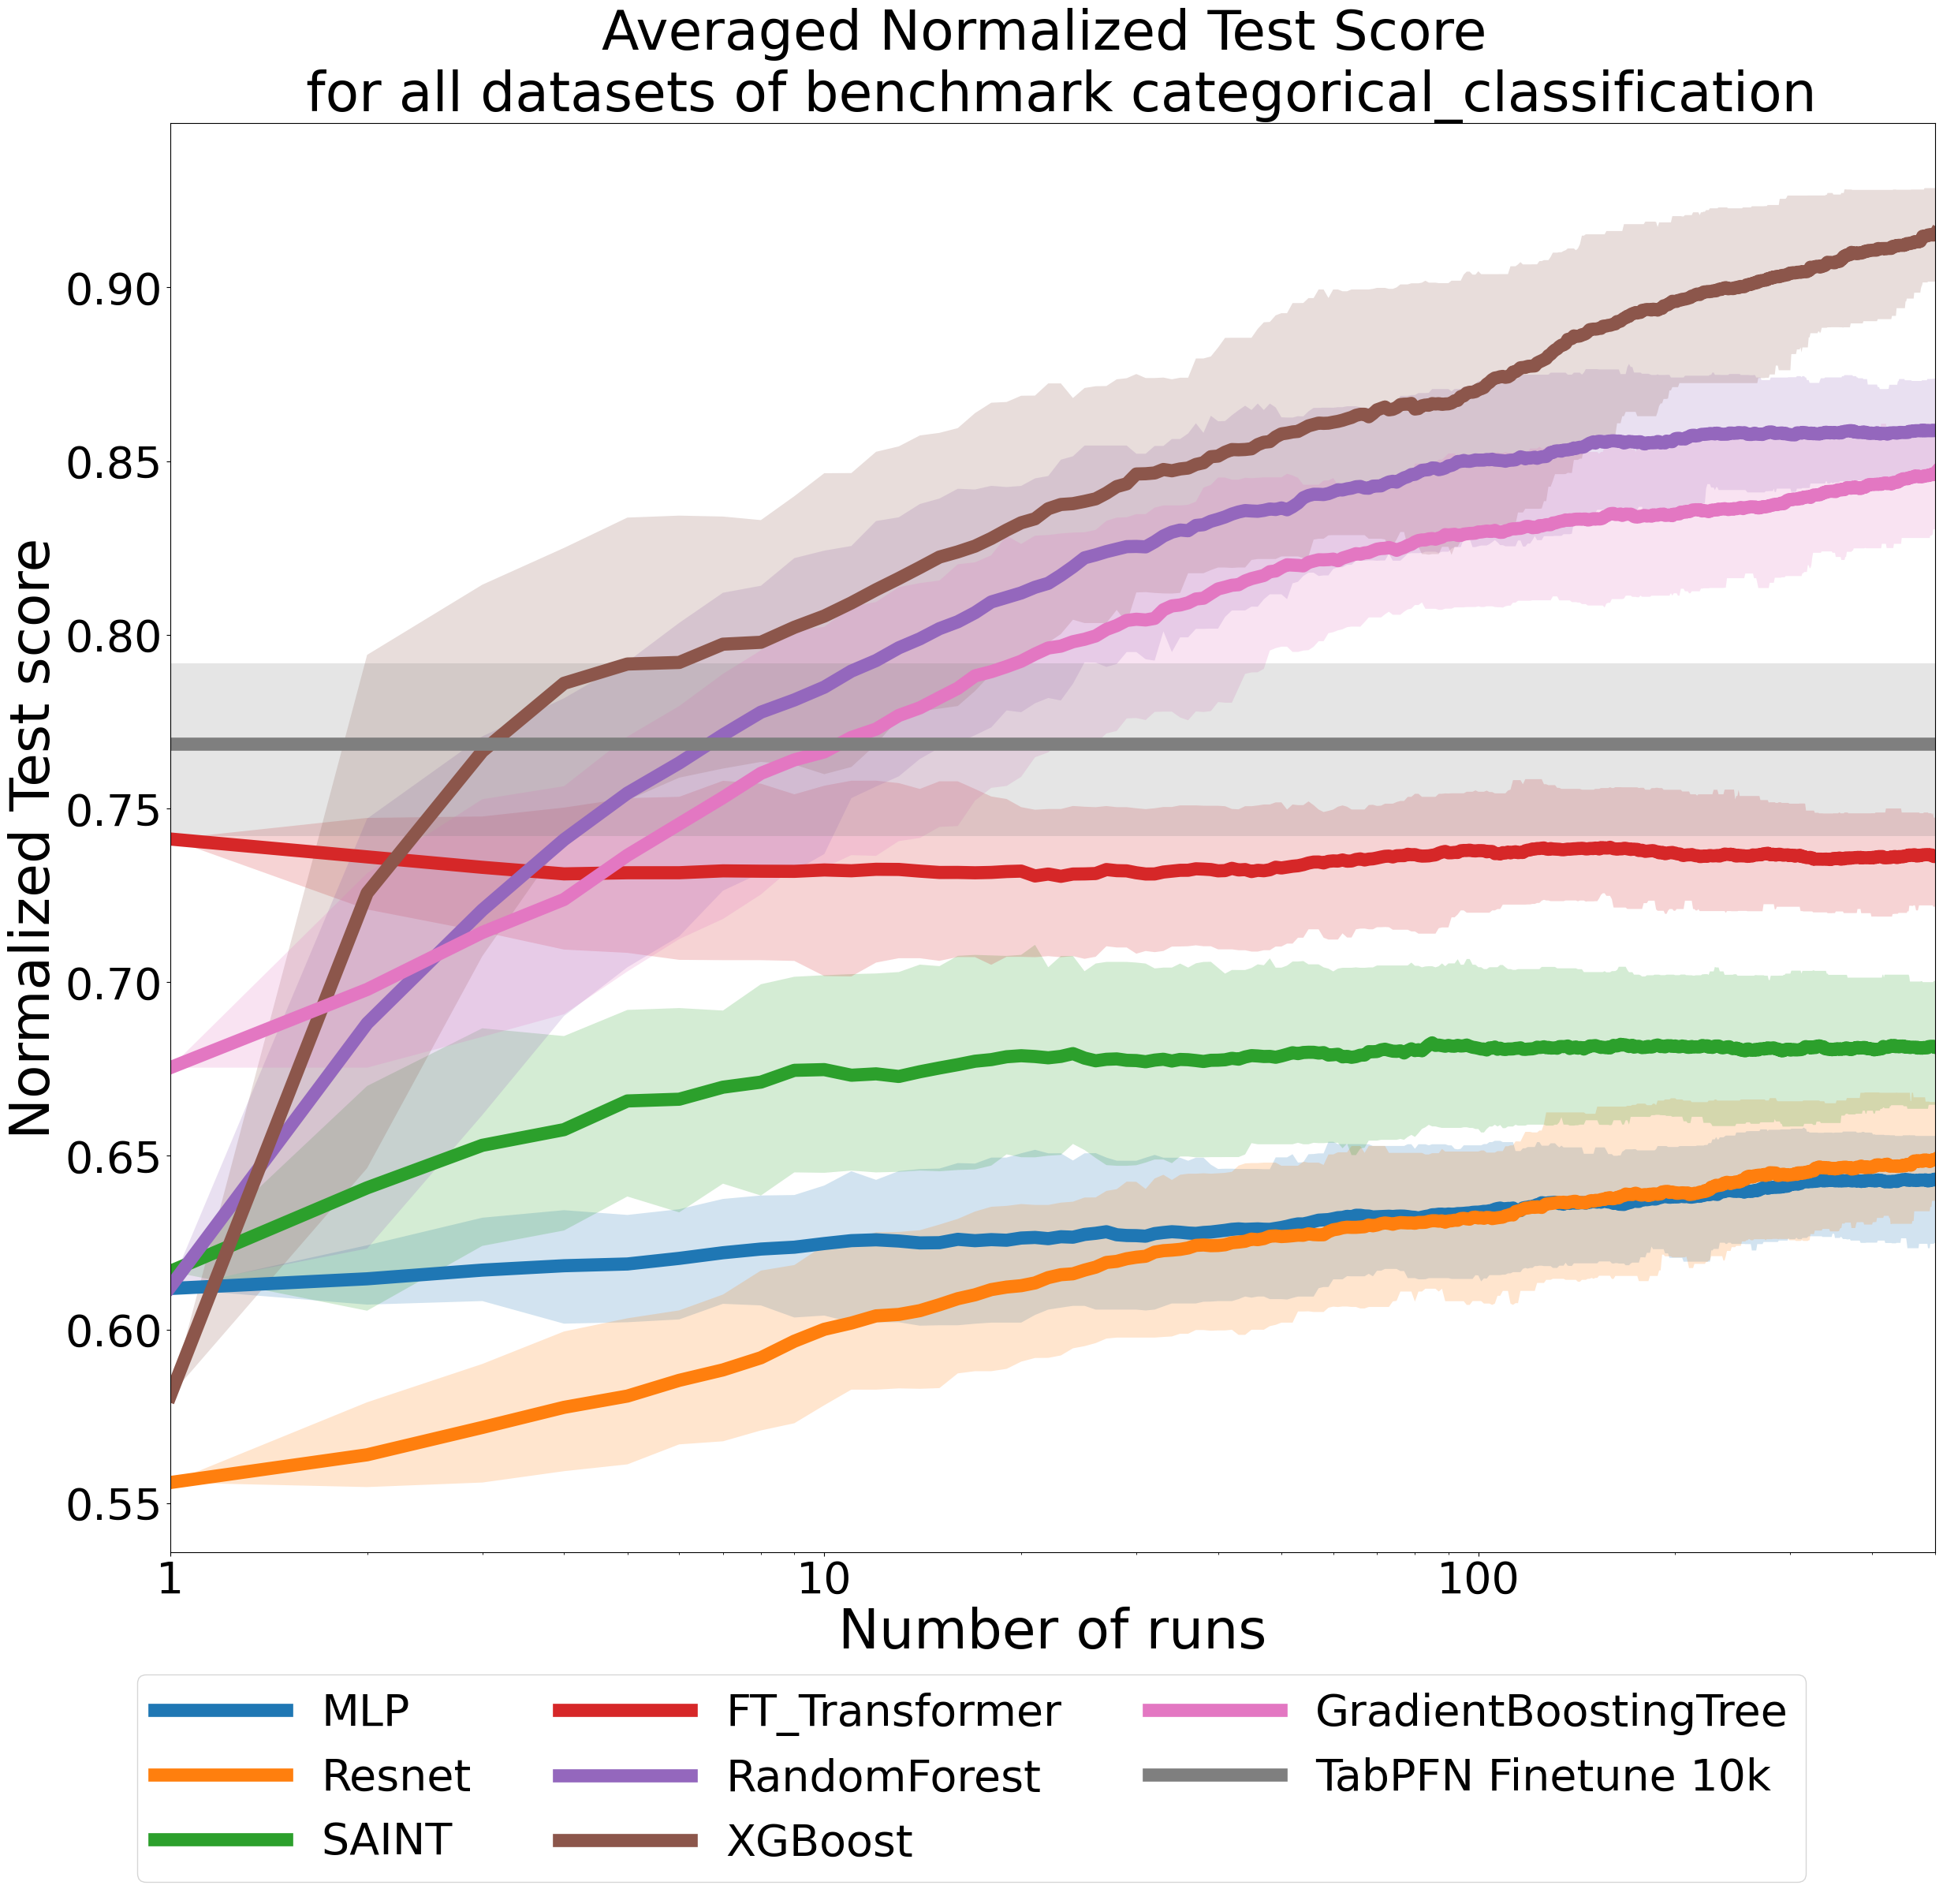

In [19]:
from tabularbench.results.dataset_plot import combine_and_process_run_results_with_benchmark
from tabularbench.results.dataset_plot_combined import make_combined_dataset_plot, make_combined_dataset_plot_data
from tabularbench.results.random_sequence import create_random_sequences_from_df
from tabularbench.results.reformat_benchmark import get_benchmark_csv_reformatted


df_bench = get_benchmark_csv_reformatted()
df_combined = combine_and_process_run_results_with_benchmark(cfg, results, df_bench)
sequences_all = create_random_sequences_from_df(cfg, df_combined)

plot_data_combined = make_combined_dataset_plot_data(cfg, sequences_all)
fig_combined = make_combined_dataset_plot(cfg, plot_data_combined)

In [13]:
sequences_all[0, 0, :, 0]

array([0.81607465, 0.81607465, 0.81607465, 0.81607465, 0.81607465,
       0.81607465, 0.81607465, 0.81607465, 0.81607465, 0.81607465,
       0.81607465, 0.81607465, 0.81607465, 0.81607465, 0.81607465,
       0.81607465, 0.81607465, 0.81607465, 0.81607465, 0.81607465,
       0.81607465, 0.81607465, 0.81607465, 0.81607465, 0.81607465,
       0.81607465, 0.81607465, 0.81607465, 0.81607465, 0.81607465,
       0.81607465, 0.81607465, 0.81607465, 0.81607465, 0.81607465,
       0.81607465, 0.81607465, 0.81607465, 0.81607465, 0.81607465,
       0.81607465, 0.81607465, 0.81607465, 0.81607465, 0.81607465,
       0.81607465, 0.81607465, 0.81607465, 0.81607465, 0.81607465,
       0.81607465, 0.81607465, 0.81607465, 0.81607465, 0.81607465,
       0.81607465, 0.81607465, 0.81607465, 0.81607465, 0.81607465,
       0.81607465, 0.81607465, 0.81607465, 0.81607465, 0.81607465,
       0.81607465, 0.81607465, 0.81607465, 0.81607465, 0.81607465,
       0.81607465, 0.81607465, 0.81607465, 0.81607465, 0.81607

/tmp/ipykernel_4107817/3614404128.py:33: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim([0, cfg.config_plotting.n_runs])


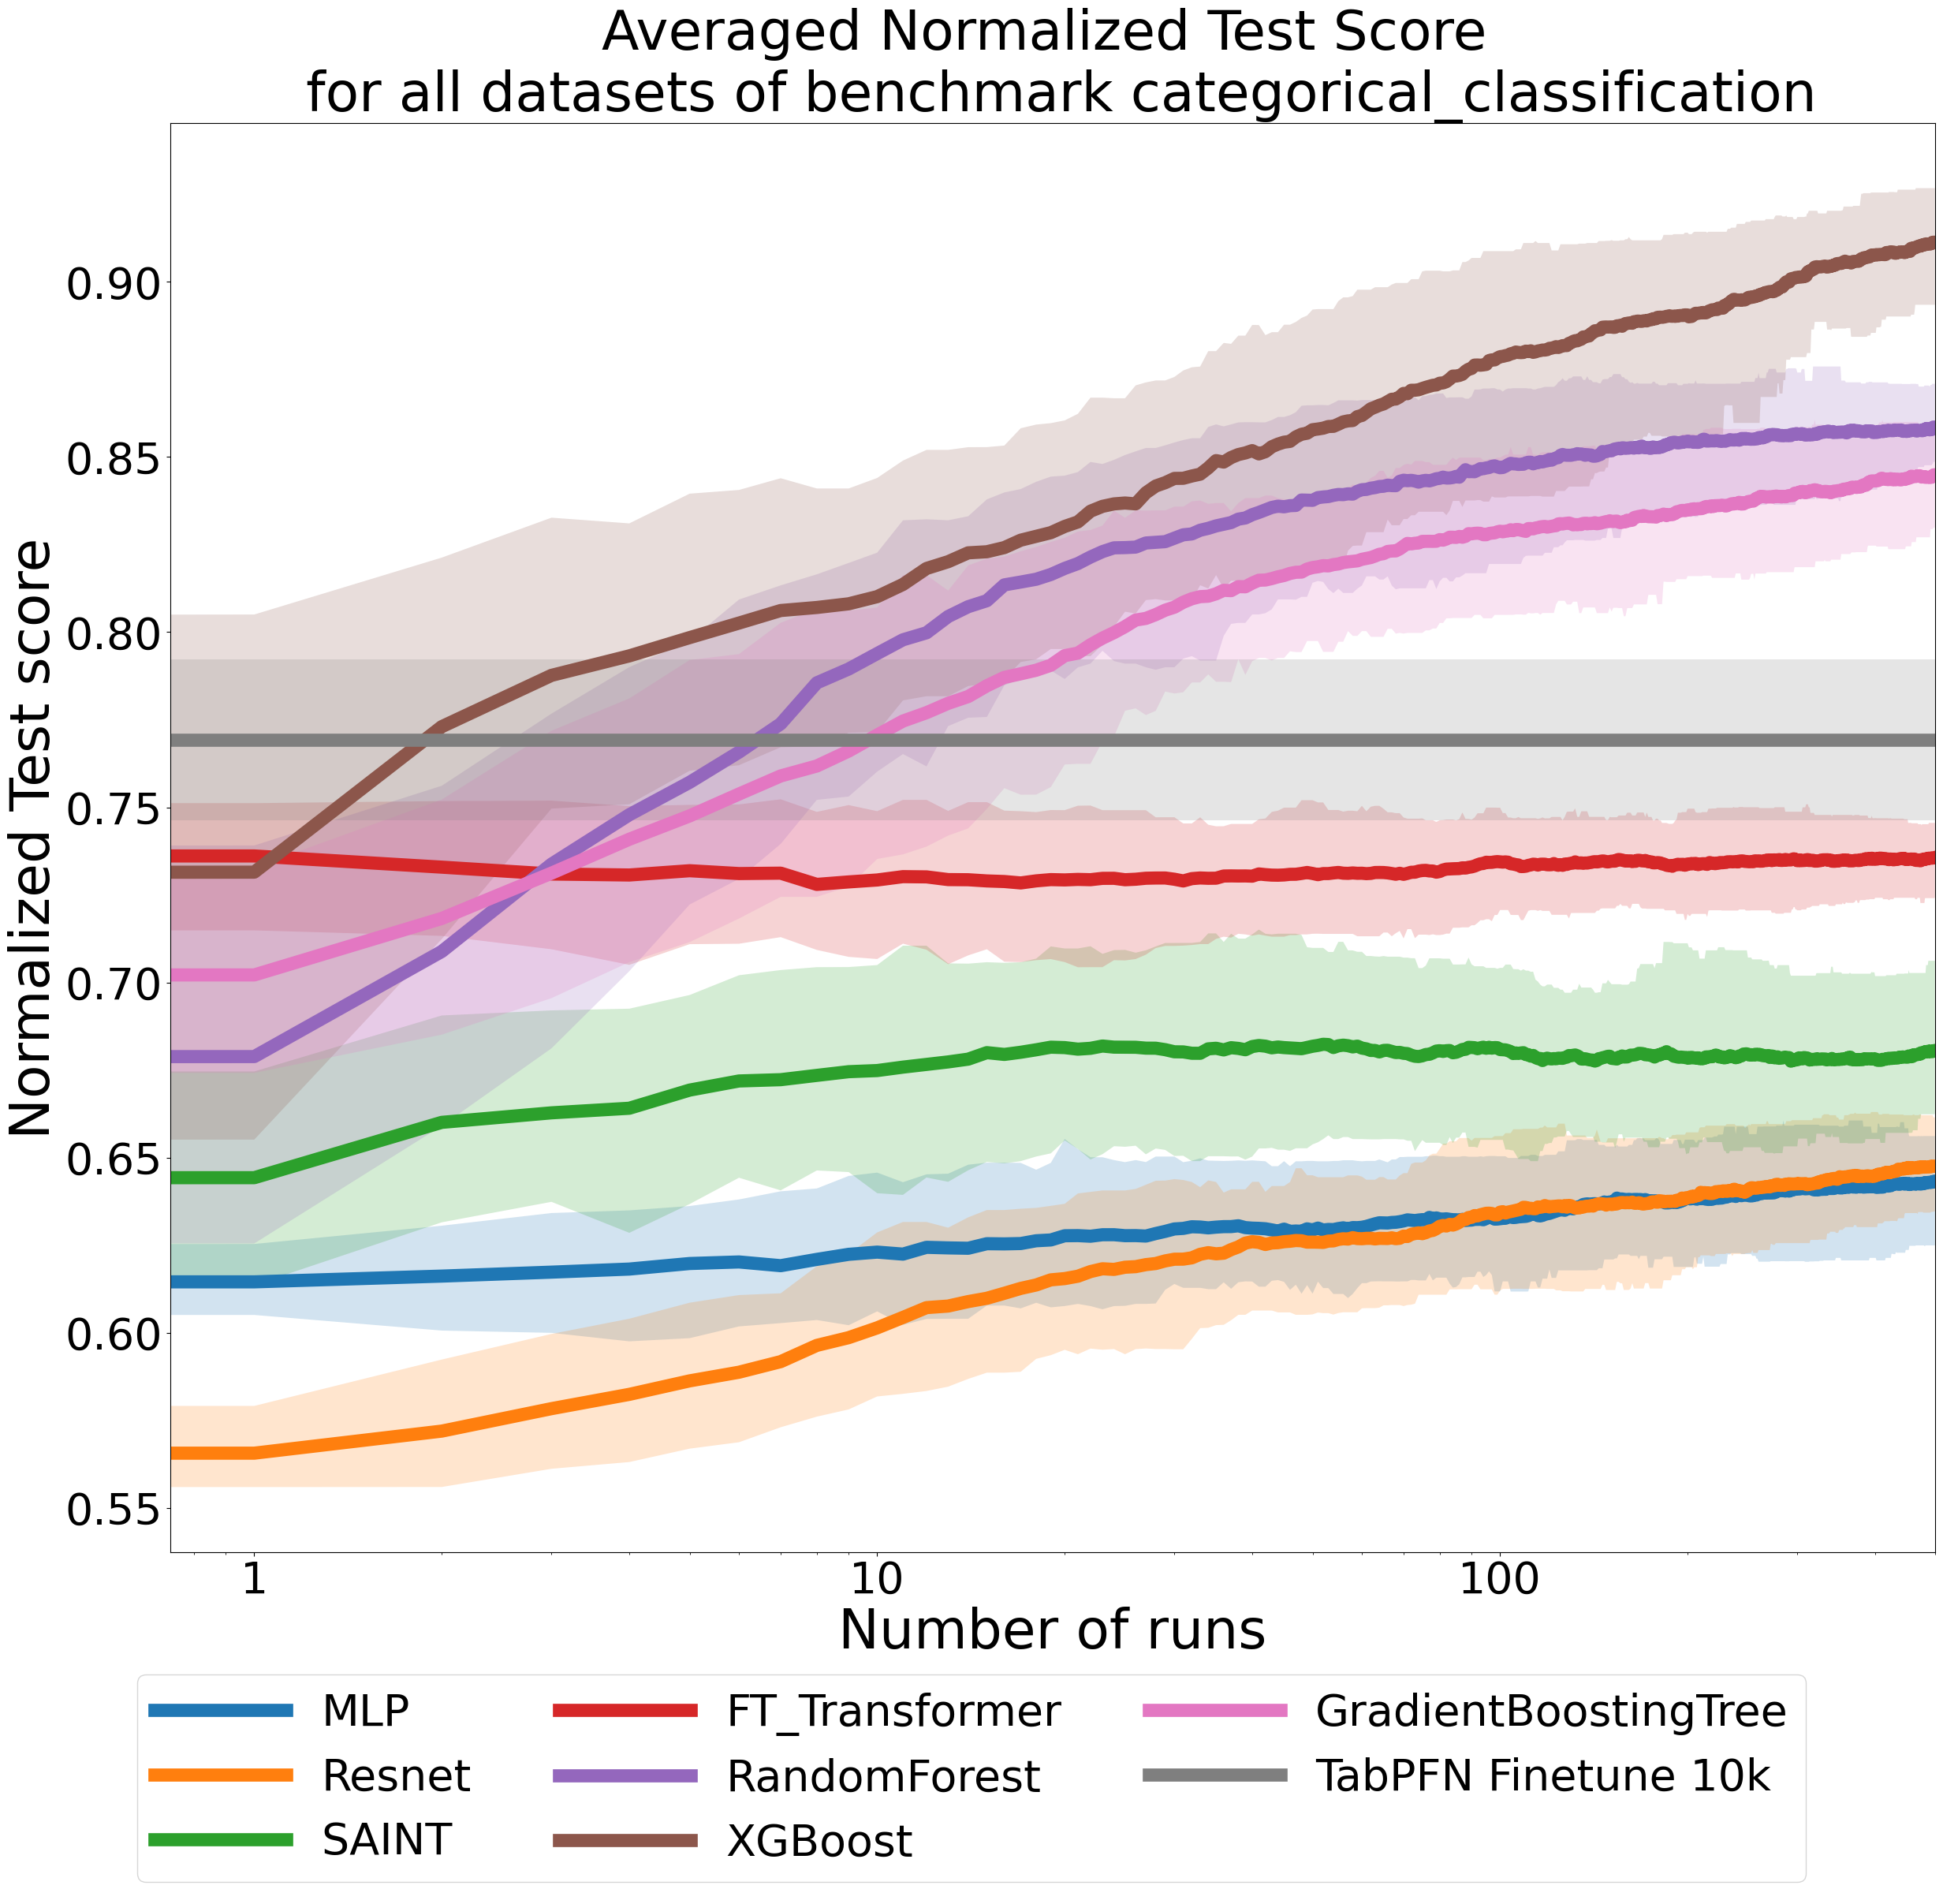

In [8]:
import math
from matplotlib import pyplot as plt
import numpy as np

from tabularbench.utils.config_benchmark_sweep import ConfigBenchmarkSweep


fig, ax = plt.subplots(figsize=(25, 25))

models = cfg.config_plotting.benchmark_model_names + [cfg.model_plot_name]

for model_i, model in enumerate(models):

    sequence_mean = plot_data_combined[0, model_i, :]
    sequence_lower_bound = plot_data_combined[1, model_i, :]
    sequence_upper_bound = plot_data_combined[2, model_i, :]

    ax.plot(sequence_mean, label=model, linewidth=12)
    ax.fill_between(
        x=np.arange(len(sequence_mean)), 
        y1=sequence_lower_bound, 
        y2=sequence_upper_bound, 
        alpha=0.2
    )


ax.set_title(f"Averaged Normalized Test Score \n for all datasets of benchmark {cfg.benchmark.name}", fontsize=50)
ax.set_xlabel("Number of runs", fontsize=50)
ax.set_ylabel("Normalized Test score", fontsize=50)
ax.tick_params(axis='both', which='major', labelsize=40)

ax.set_xscale('log')
ax.set_xlim([0, cfg.config_plotting.n_runs])
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=40, handlelength=3)
fig.tight_layout(pad=2.0, rect=[0, 0.12, 1, 0.98])

    